# Extracting features from an audio file

In [ ]:
!pip install pydub

In [ ]:
# Some python imports
from pydub import AudioSegment
import os
import matplotlib
import matplotlib.pyplot as plt
import pylab
import librosa
import librosa.display
import numpy as np
import scipy
import IPython
%matplotlib inline



In [ ]:
# Functions

RANDOM = np.random.RandomState(1337)
CACHE = {}

# generate Noise - used for overlap
def noise(sig, shape, amount=None):

    # Random noise intensity
    if amount == None:
        amount = RANDOM.uniform(0.1, 0.9)

    # Create Gaussian noise
    noise = RANDOM.normal(min(sig) * amount, max(sig) * amount, shape)

    return noise
    
# split the signal into frames
def splitSignal(sig, rate, seconds, overlap, minlen):

    # Split signal with overlap
    sig_splits = []
    for i in range(0, len(sig), int((seconds - overlap) * rate)):
        split = sig[i:i + int(seconds * rate)]

        # End of signal?
        if len(split) < int(minlen * rate):
            break
        
        # Signal chunk too short?
        if len(split) < int(rate * seconds):
            split = np.hstack((split, noise(split, (int(rate * seconds) - len(split)), 0.5)))
        
        sig_splits.append(split)

    return sig_splits

def buildBandpassFilter(rate, fmin, fmax, order=4):

    global CACHE

    fname = 'bandpass_' + str(rate) + '_' + str(fmin) + '_' + str(fmax)
    if not fname in CACHE:
        wn = np.array([fmin, fmax]) / (rate / 2.0)
        filter_sos = scipy.signal.butter(order, wn, btype='bandpass', output='sos')

        # Save to cache
        CACHE[fname] = filter_sos

    return CACHE[fname]
def applyBandpassFilter(sig, rate, fmin, fmax):

    # Build filter or load from cache
    filter_sos = buildBandpassFilter(rate, fmin, fmax)

    return scipy.signal.sosfiltfilt(filter_sos, sig)

# print the mel spectogram
def printMel(sig):
  S = librosa.feature.melspectrogram(sig ,sr=fs)
  fig=librosa.display.specshow(librosa.power_to_db(S, ref=np.max),x_axis='time',y_axis='linear')

# print the chroma spectrum
def printChroma(sig):

  chroma=librosa.feature.chroma_stft(sig)
  fig, ax = plt.subplots()
  img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
#  fig.colorbar(img, ax=ax)
  ax.set(title='Chromagram')

def printRMS_Mel(sig):
  rms=librosa.feature.rms(sig)
  fig, ax = plt.subplots(nrows=2, sharex=True)

  times = librosa.times_like(rms)
  ax[0].semilogy(times, rms[0], label='RMS')
  ax[0].set(xticks=[])
  ax[0].legend()
  ax[0].label_outer()
  S = librosa.feature.melspectrogram(sig ,sr=fs)
  librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),
                          y_axis='linear', x_axis='time', ax=ax[1])
  ax[1].set(title='Power spectrogram')

def printRMS(sig):
  rms=librosa.feature.rms(sig)
  
  times = librosa.times_like(rms)
  plt.plot(times,rms[0])
  plt.show()

## Upload the file
`recording.wav`

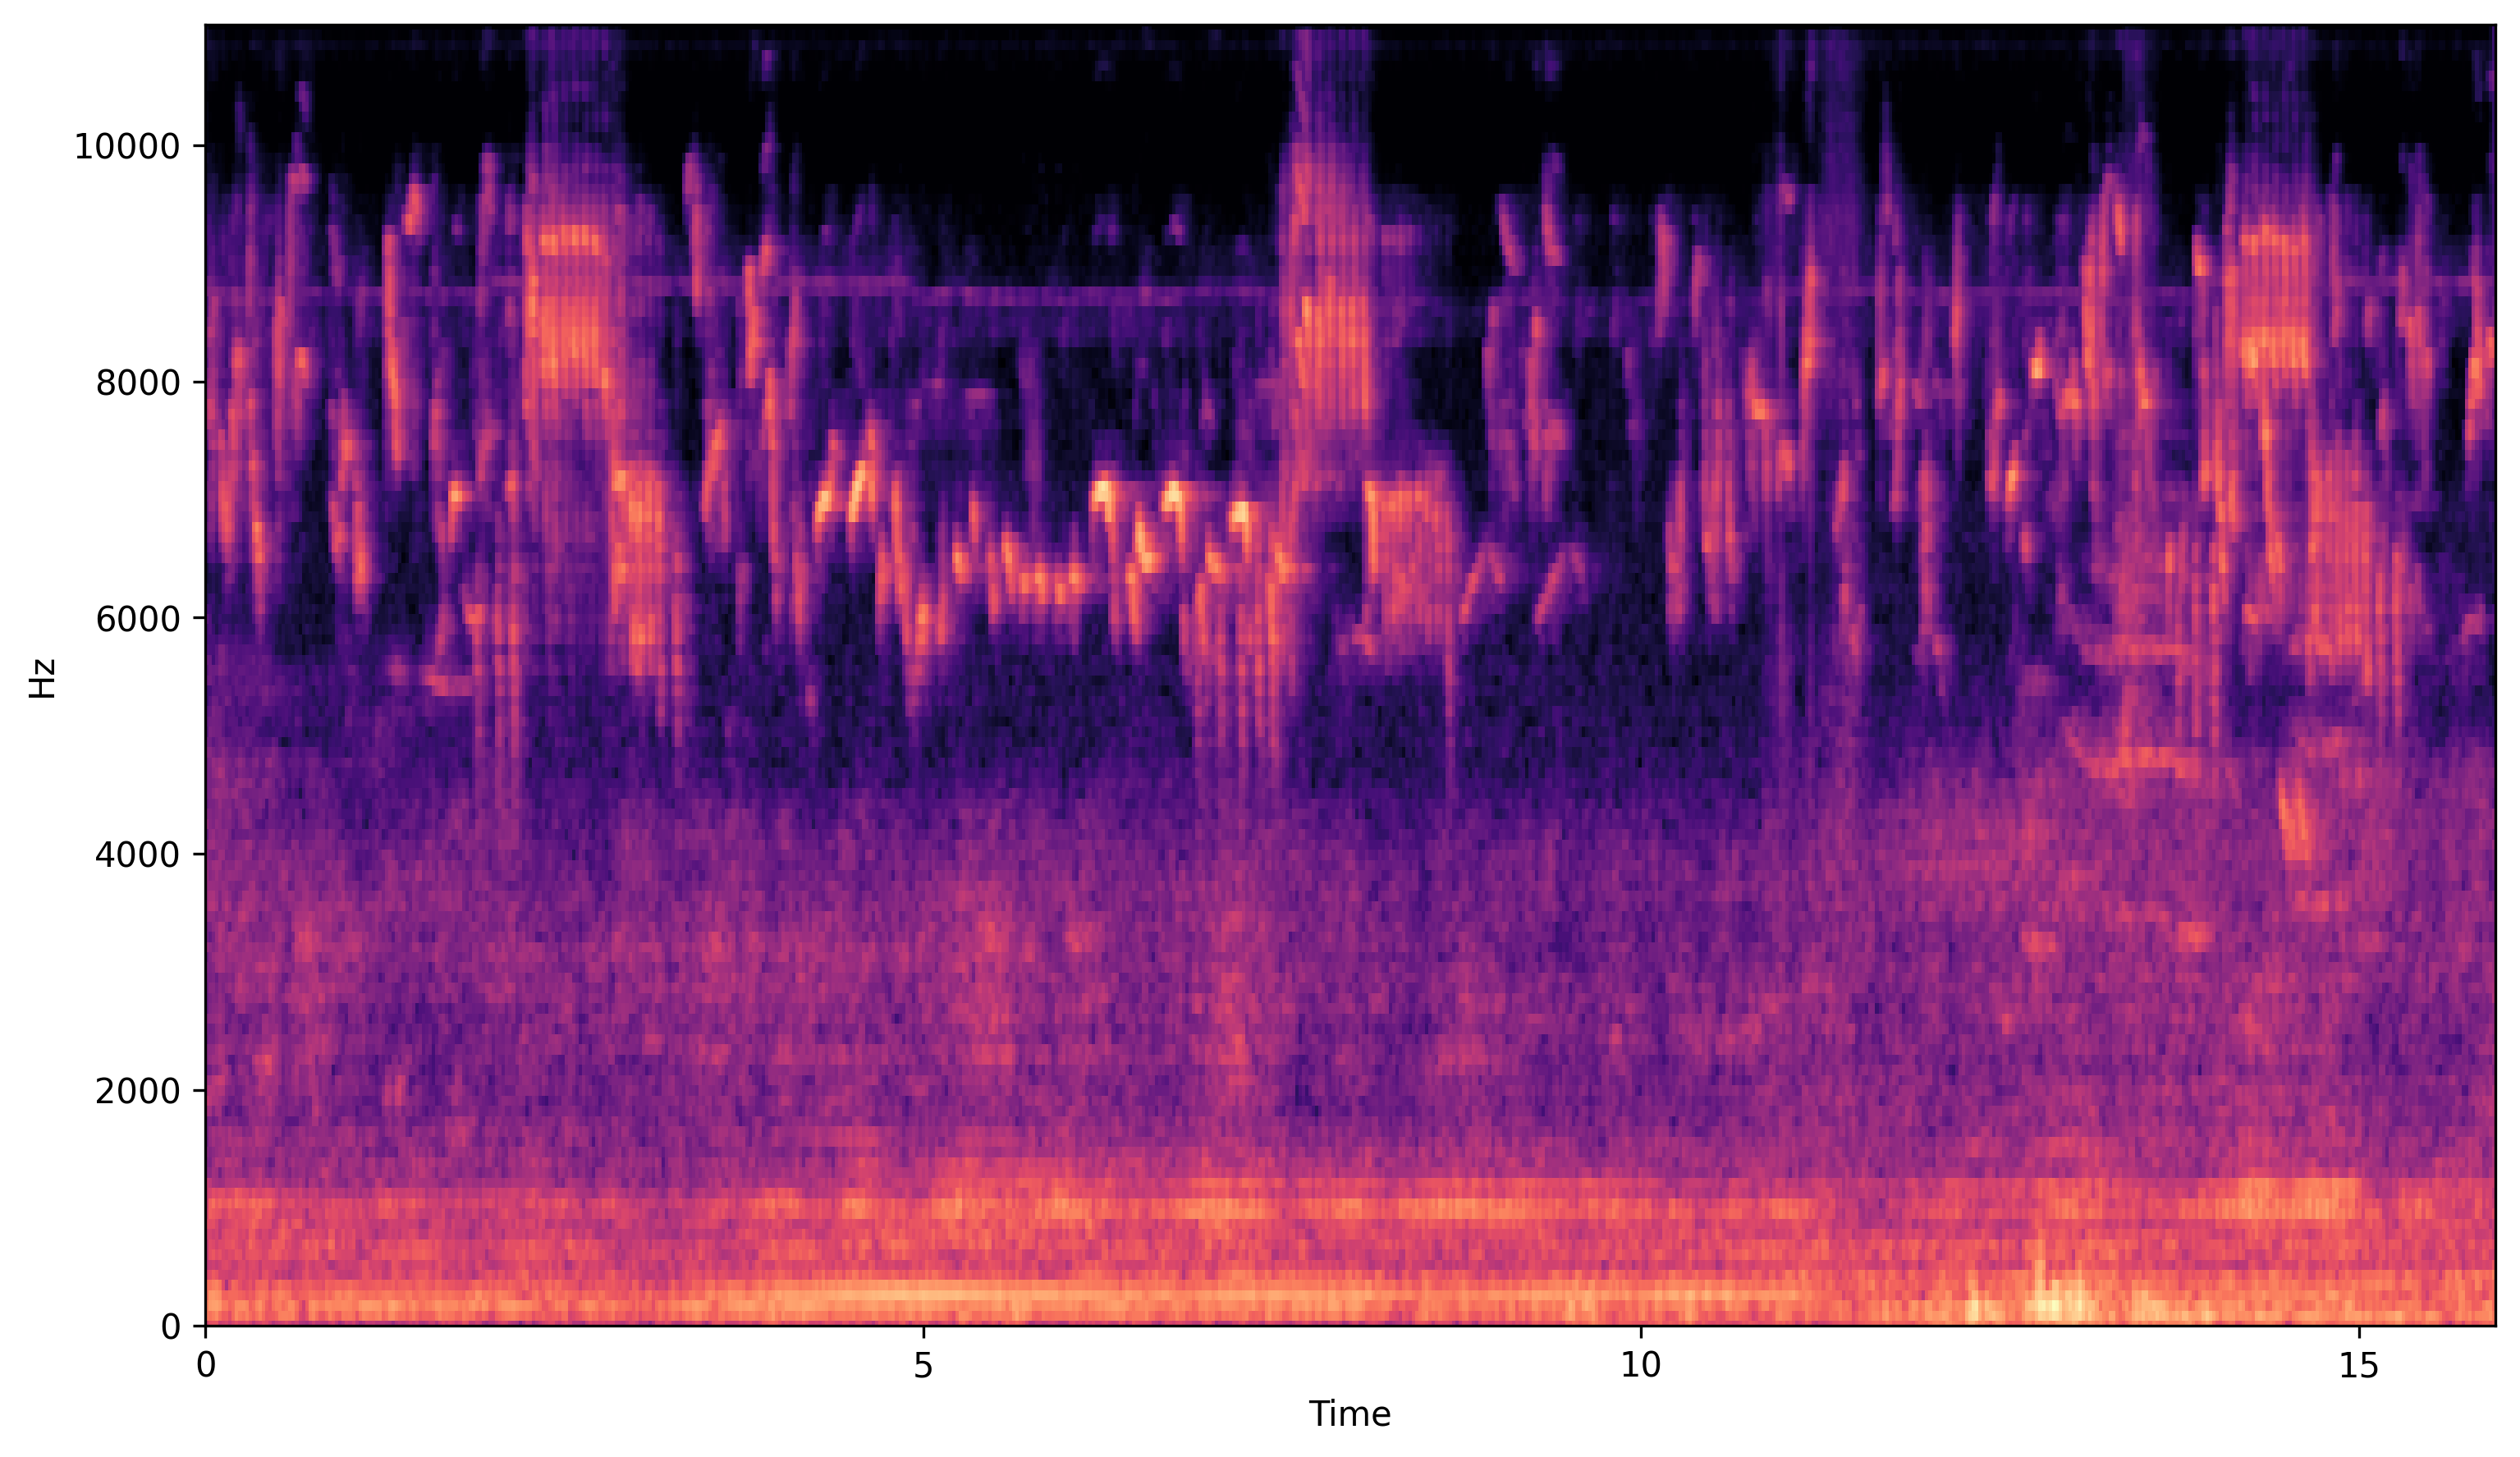

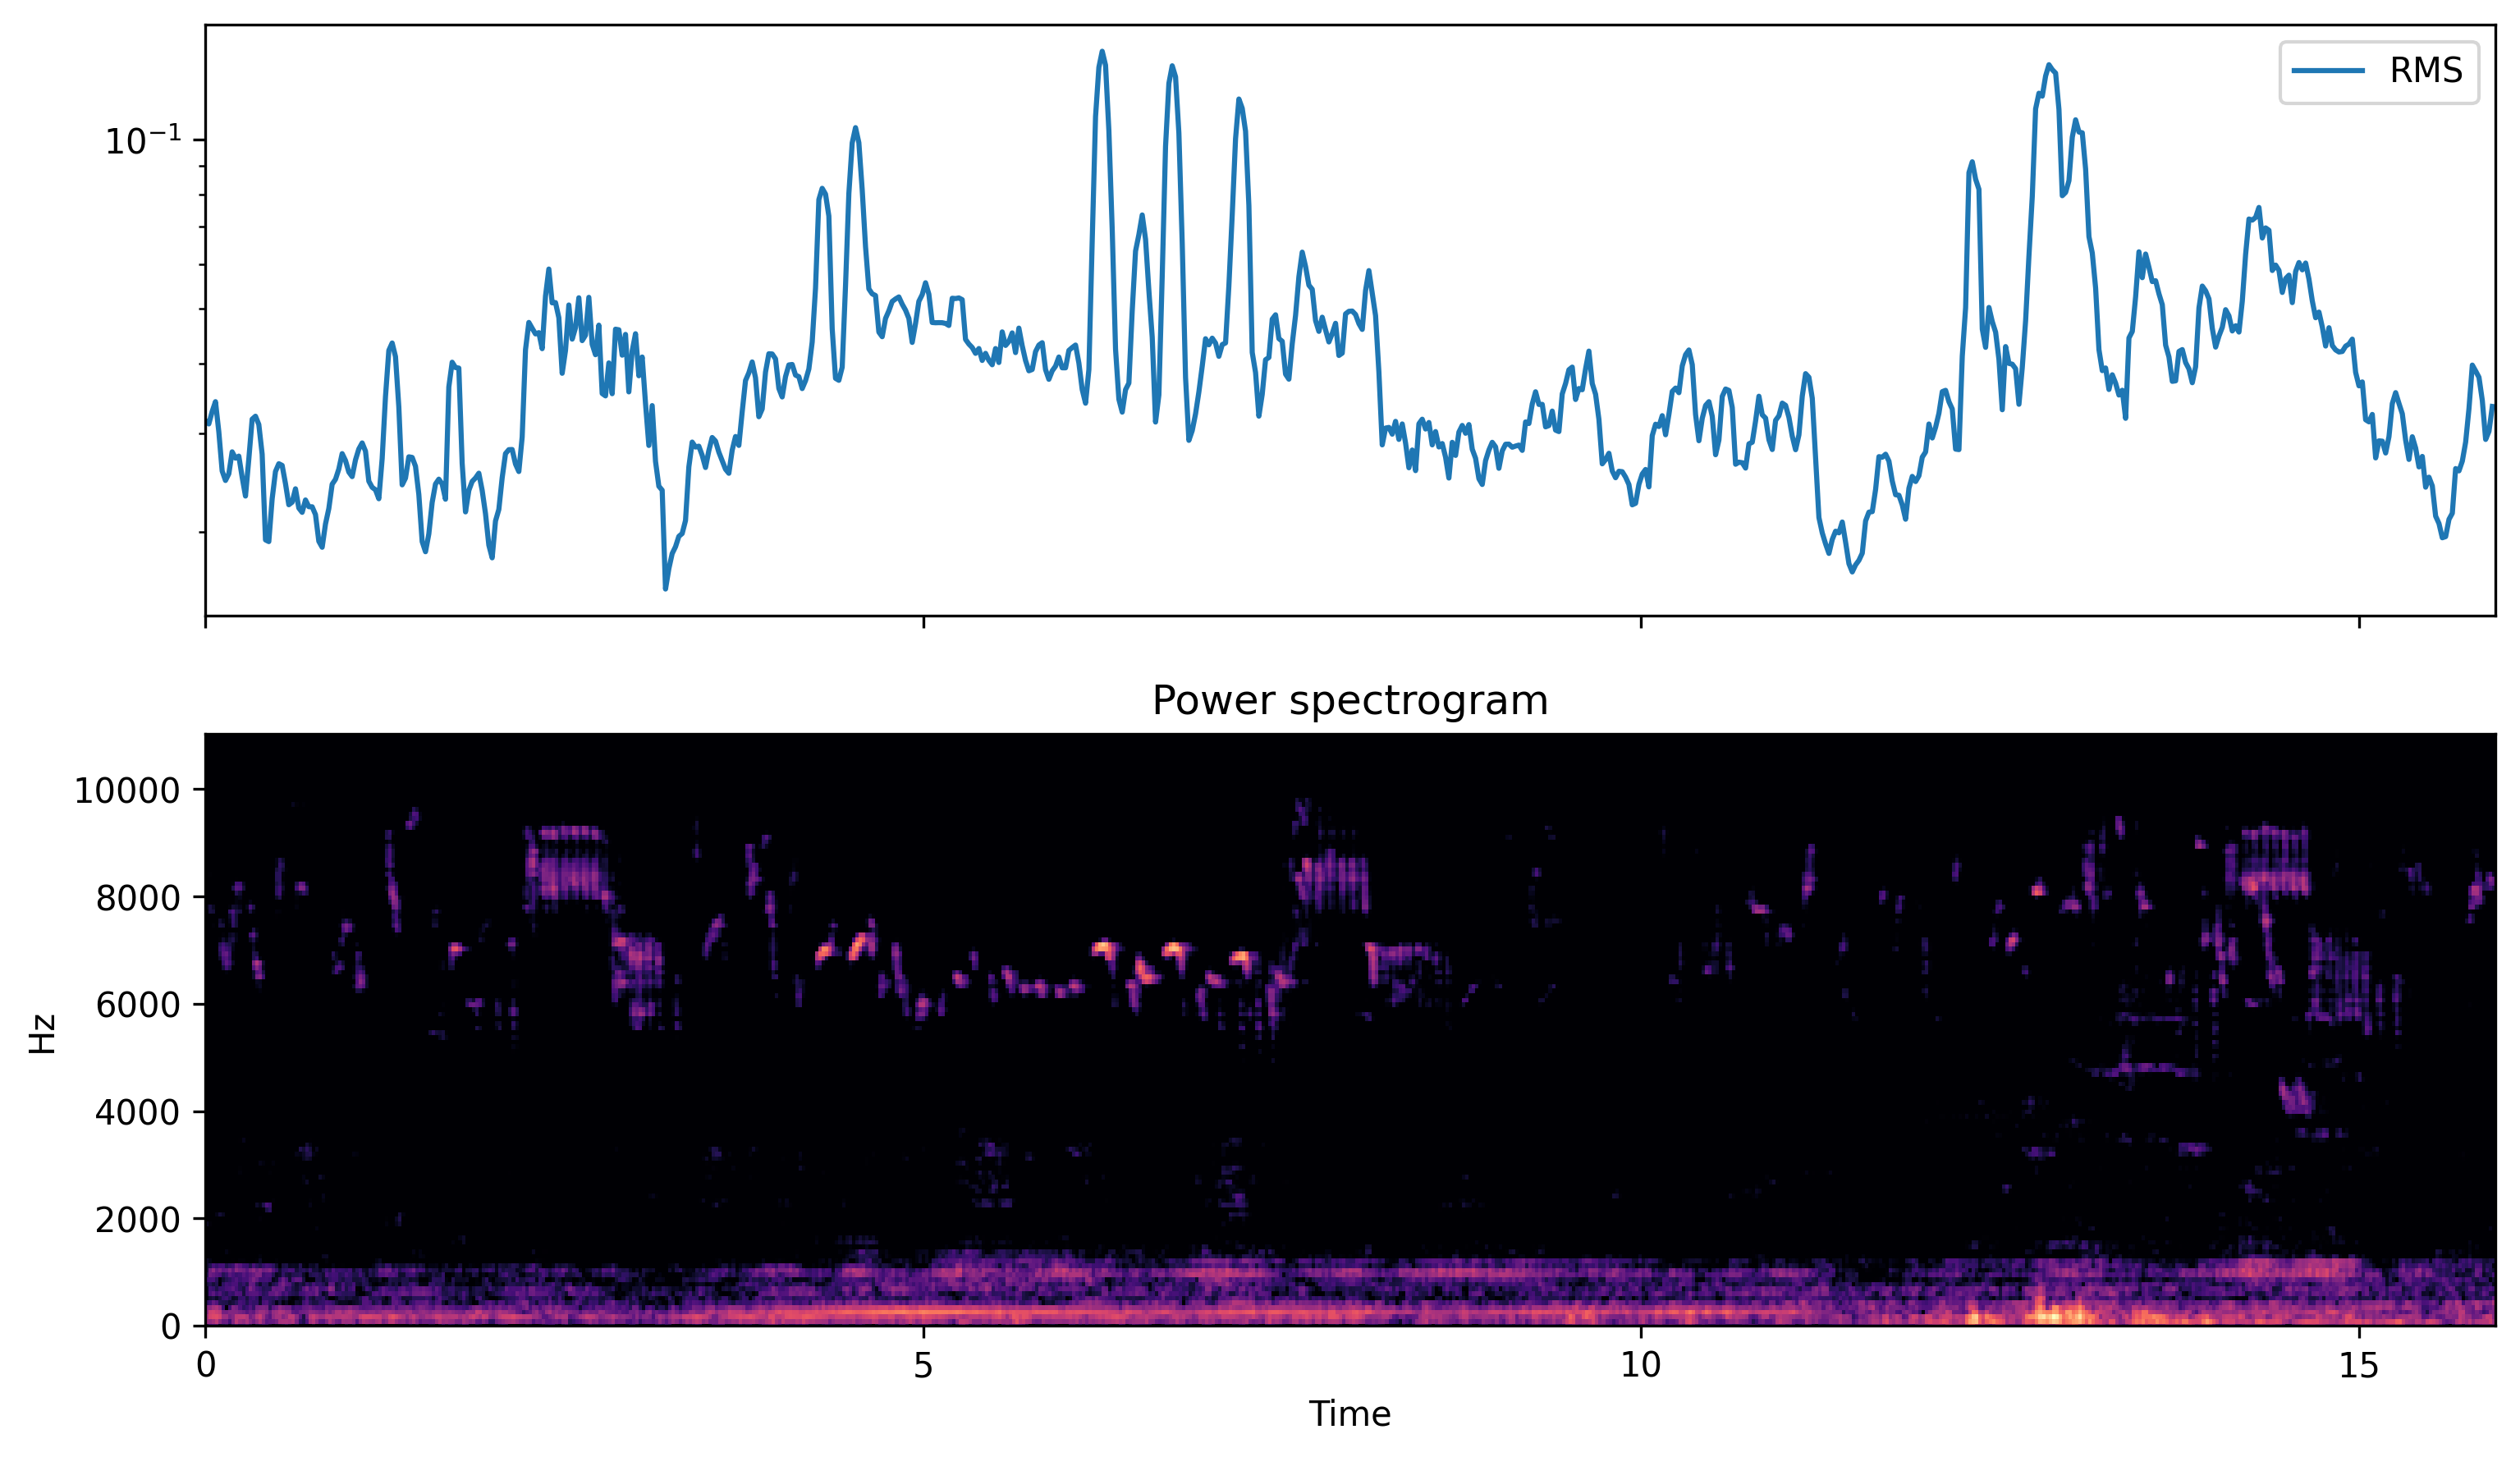

In [ ]:
# Mel spectogram of the whole audio
sig, fs = librosa.load('recording.wav')   

printMel(sig)
printRMS_Mel(sig)

In [ ]:
# Play
IPython.display.Audio("recording.wav") 

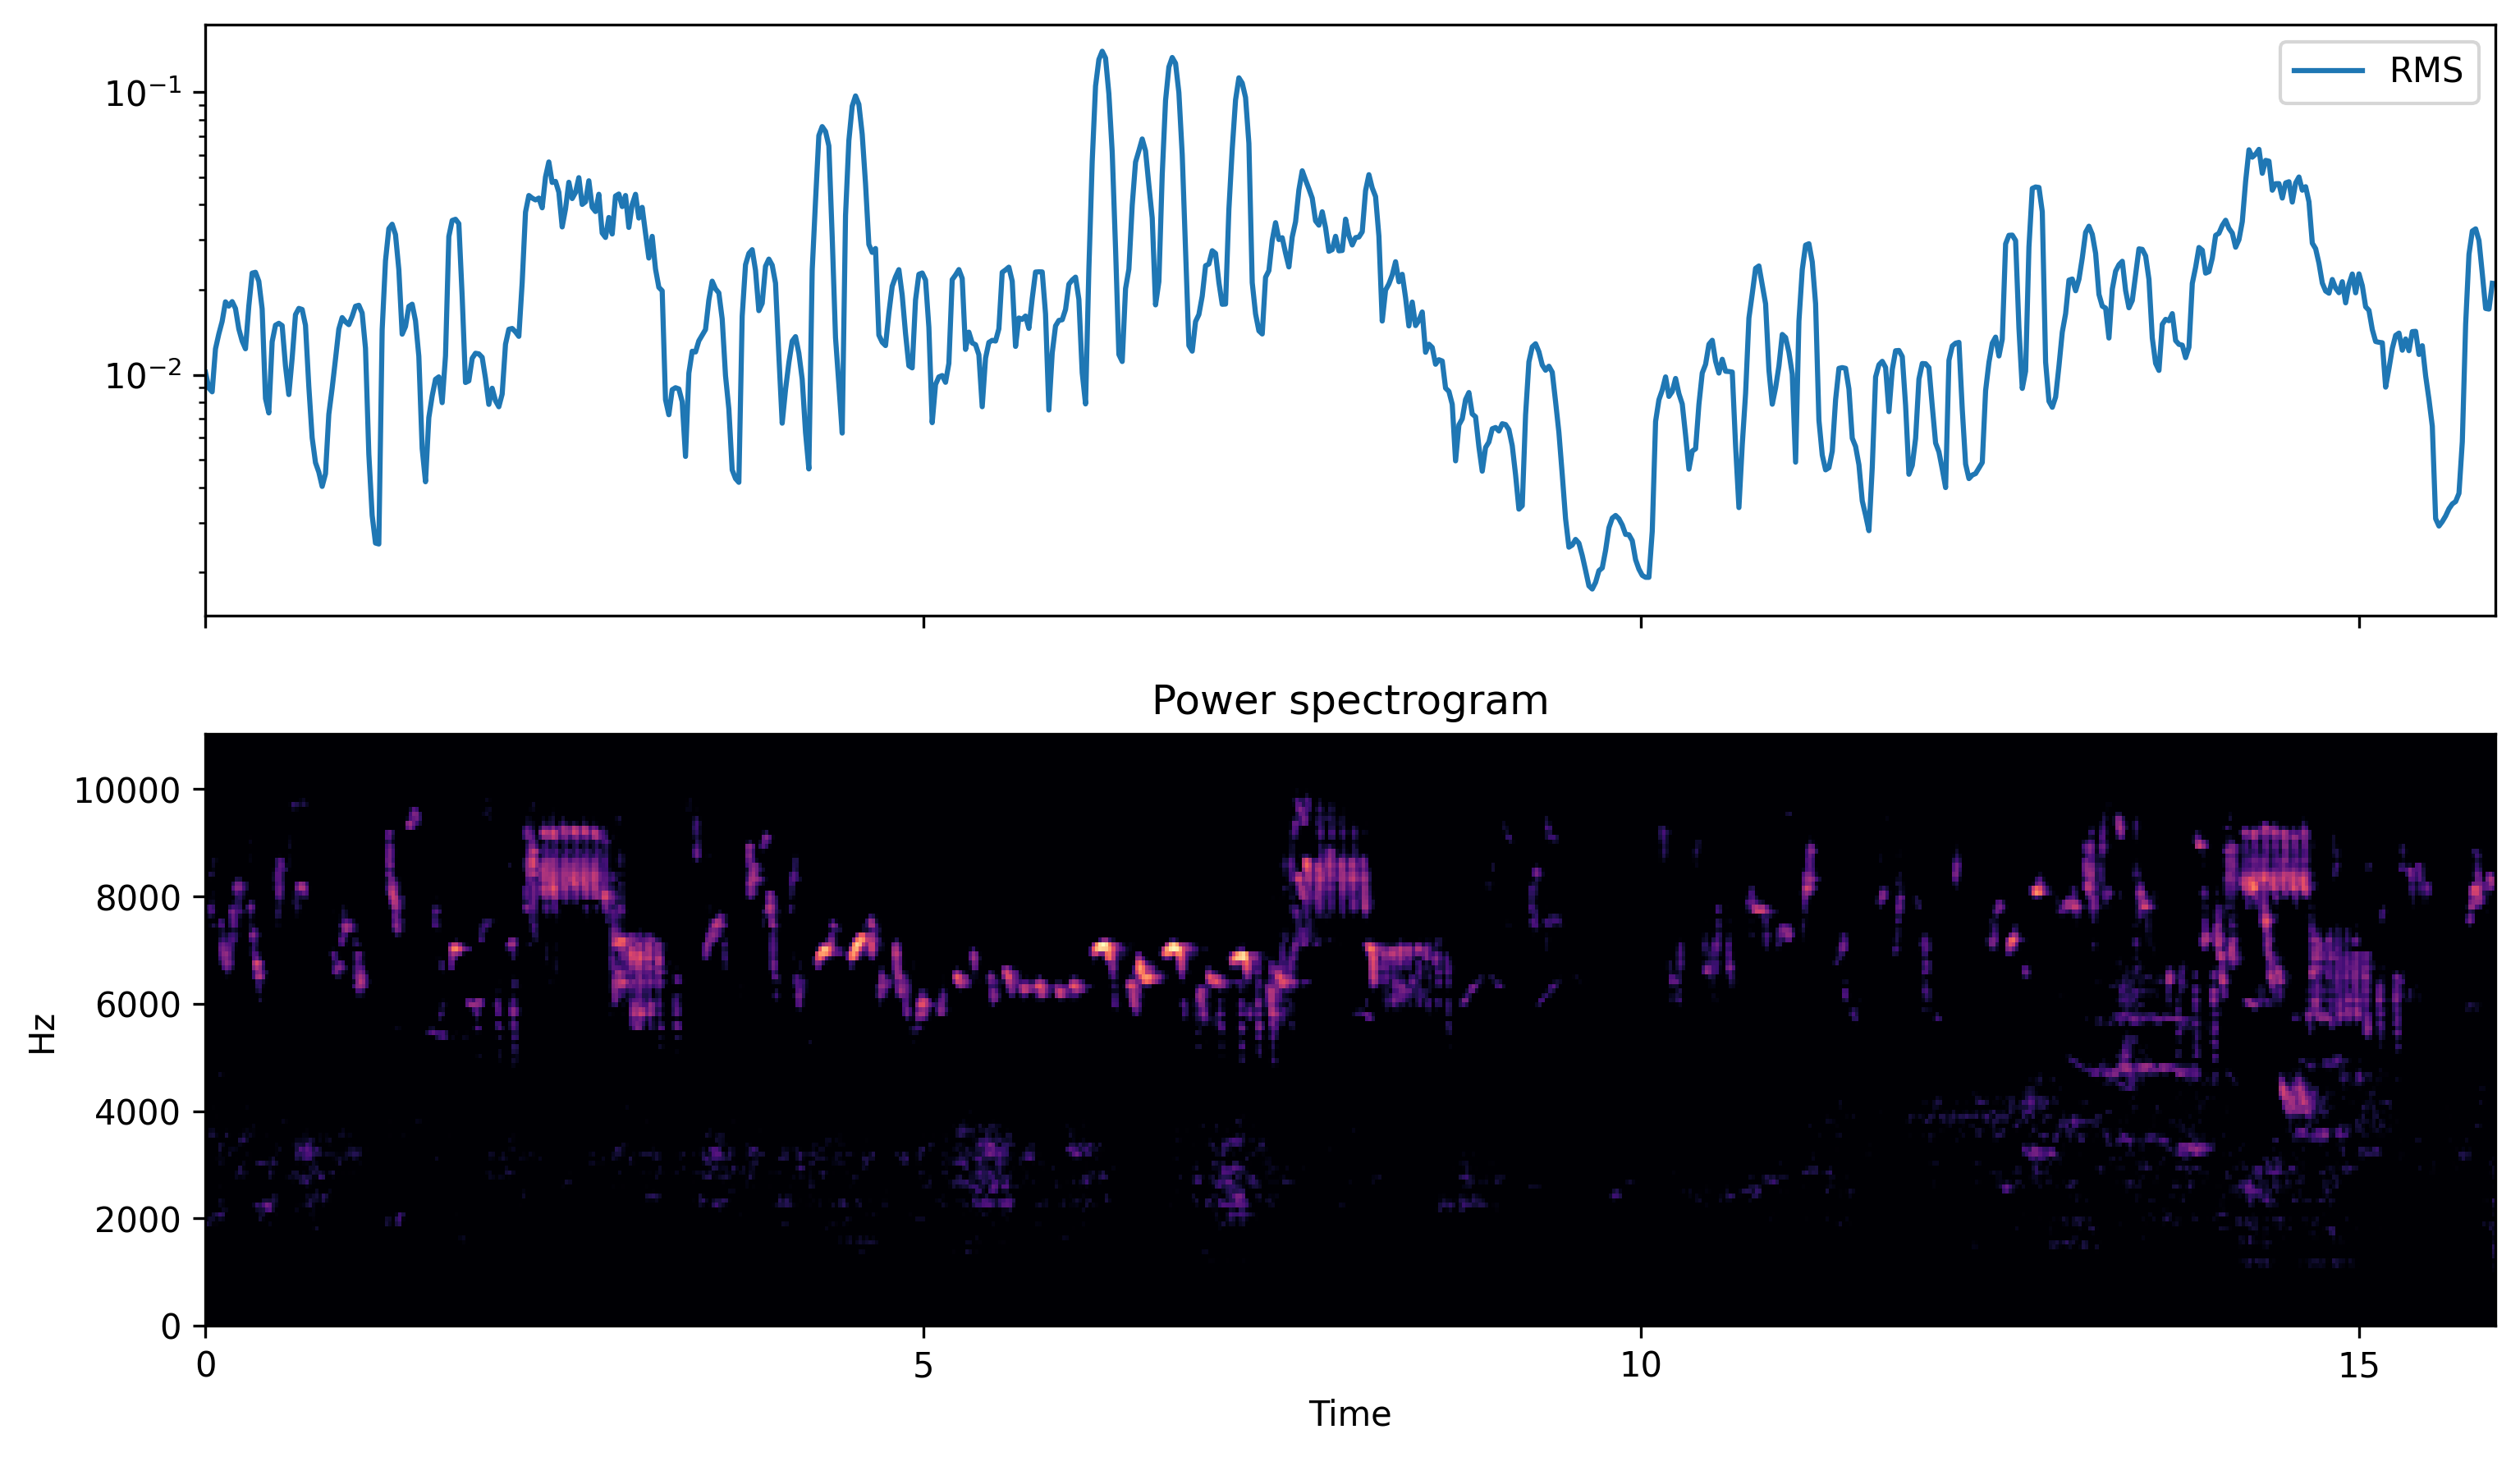

In [ ]:
printRMS_Mel(applyBandpassFilter(sig,fs,500,11024))

In [ ]:
# Split recording
frames = splitSignal(sig,fs,3,1.5,1)
frames_splitOnly=splitSignal(sig,fs,3,0,1)
print("The signal is split into ",len(frames)," frames")


In [ ]:
first_bandPass = applyBandpassFilter(frames[0],fs,500,10000)

In [ ]:
printMel(first_bandPass)

In [ ]:
printRMS_Mel(first_bandPass)

In [ ]:
#printRMS(first_bandPass)
#printMel(first_bandPass)
printRMS_Mel(applyBandpassFilter(splitSignal(sig,fs,6,0,0)[0],fs,1000,11024))
printRMS_Mel(splitSignal(sig,fs,6,0,0)[0])
#printRMS_Mel(applyBandpassFilter(sig,fs,500,11024))




In [ ]:
# Enlarge graphs
plt.rcParams['figure.figsize'] = [12, 7]
plt.rcParams['figure.dpi'] = 300

In [ ]:
printRMS_Mel(sig)
printRMS_Mel(applyBandpassFilter(sig,fs,1500,11024))

In [ ]:
# save something
import soundfile
soundfile.write("bp_1k.wav", applyBandpassFilter(sig,fs,1000,11024),fs)
